## Introduction

### In this notebook we use [DeepLabV3+](https://arxiv.org/abs/1802.02611) segmentation model for performing building segmentation

### Libraries 📚⬇

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [2]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Defining train / val / test directories 📁

In [3]:
#教師データを格納しているgoogleドライブの場所を入れる
DATA_DIR = '../input/camvid/CamVid/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [4]:
#csvに色とラベルの対応を入れておくこと
#name,r,g,b
#background,0,0,0
#aji,128,0,0
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall']
Class RGB values:  [[64, 128, 64], [192, 0, 128], [0, 128, 192], [0, 128, 64], [128, 0, 0], [64, 0, 128], [64, 0, 192], [192, 128, 64], [192, 192, 128], [64, 64, 128], [128, 0, 192], [192, 0, 64], [128, 128, 64], [192, 0, 192], [128, 64, 64], [64, 192, 128], [64, 64, 0], [128, 64, 128], [128, 128, 192], [0, 0, 192], [192, 128, 128], [128, 128, 128], [64, 128, 192], [0, 0, 64], [0, 64, 64], [192, 64, 128], [128, 128, 0], [192, 128, 192], [64, 0, 64], [192, 192, 0], [0, 0, 0], [64, 192, 0]]


#### Shortlist specific classes to segment

In [5]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['Void', 'Sidewalk', 'Car', 'Road', 'Tree', 'Pedestrian']

# Get RGB values of required classes
#select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_indices = [class_names.index(cls) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', select_classes)
print('Class RGB values: ', select_class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['Void', 'Sidewalk', 'Car', 'Road', 'Tree', 'Pedestrian']
Class RGB values:  [[  0   0   0]
 [  0   0 192]
 [ 64   0 128]
 [128  64 128]
 [128 128   0]
 [ 64  64   0]]


### Helper functions for viz. & one-hot encoding/decoding

In [6]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [7]:
'''
データセット作成のポイント
1. torch.utils.data.Datasetを継承したClassとして作成する
2. コンストラクタ(__init__)では、生データの格納場所を渡す
3. Classには最低でも、__getitem__メソッド、__len__メソッドを作成
4. __getitem__メソッドは、学習もしくは推論データと学習する特徴(学習時のみ)を返す
5. ___len__メソッドはデータセットの長さを返す

'''

class BuildingsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    

    def __getitem__(self, i):
        '''
        　　__getitem__メソッドでは、コンストラクタで定義したディレクトリから
        　　データを１つずつ取得し、必要な処理を適用した後、データセットを返す
        '''    
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        #__len__メソッドでは、コンストラクタで指定した生データの長さを取得して返す
        return len(self.image_paths)

#### Visualize Sample Image and Mask 📈

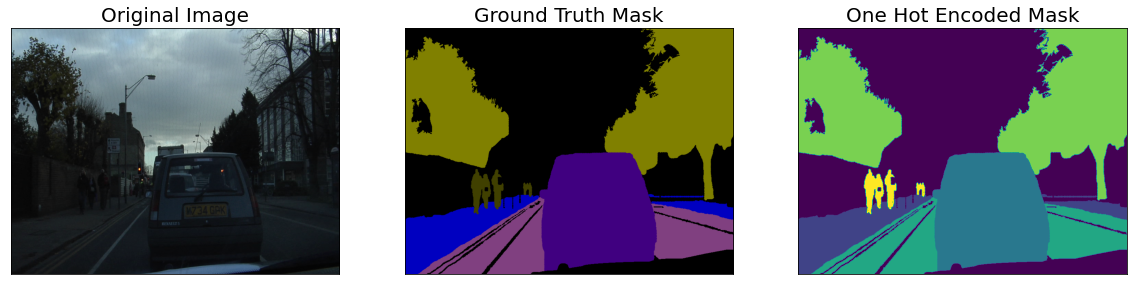

In [8]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Defining Augmentations 🙃

In [9]:
def get_training_augmentation():
    train_transform = [    
        #album.RandomCrop(height=80, width=80, always_apply=True),
        #album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                #album.VerticalFlip(p=1),
                #album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    # 画像のshapeが32で割り切れるようにPaddingするための関数
    #test_transform = [album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),]
    test_transform = [album.PadIfNeeded(min_height=1024, min_width=1024, always_apply=True, border_mode=0),]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

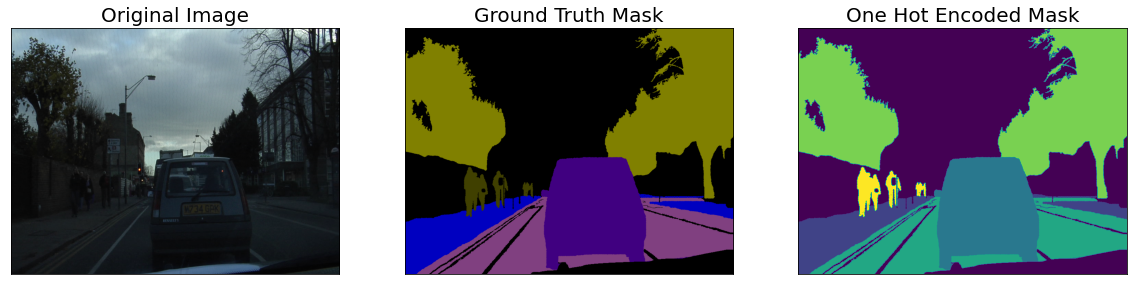

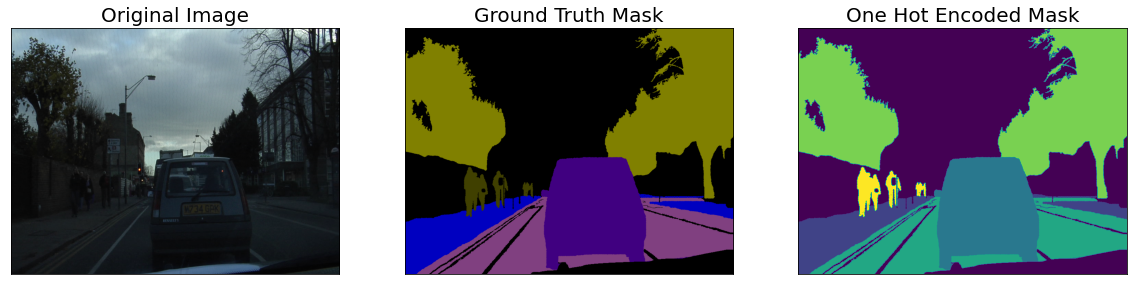

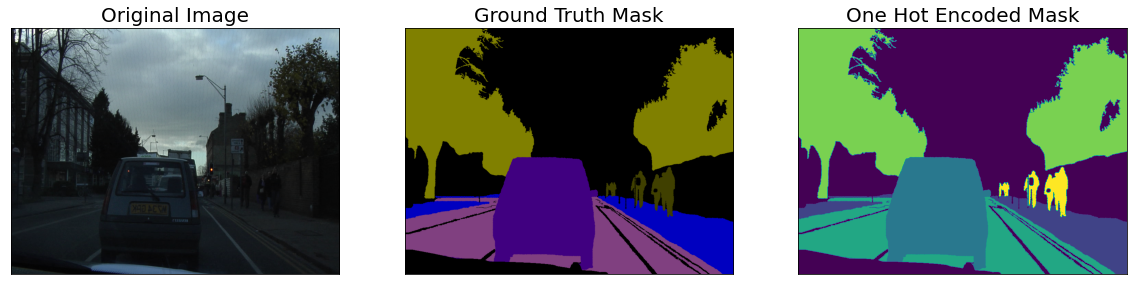

In [10]:
#やらなくて良い

augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Training DeepLabV3+ with Pretrained ResNet101 Encoder

<h3><center>DeepLabV3+ Model Architecture</center></h3>
<img src="https://miro.medium.com/max/1037/1*2mYfKnsX1IqCCSItxpXSGA.png" width="750" height="750"/>
<h4><center><a href="https://arxiv.org/abs/1802.02611">Image Courtesy: DeepLabV3+ [Chen et al.]</a></center></h4>

### Model Definition

In [11]:
ENCODER = 'resnet101'  # バックボーンネットワークの指定
ENCODER_WEIGHTS = 'imagenet'  # 使用する学習済みモデル
#CLASSES = class_names
CLASSES = select_classes

ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

#### Get Train / Val DataLoaders

In [12]:
'''
学習/推論ループでデータセットを読み込むためにデータローダーを作成
データローダーの作成は簡単
torch.utils.data.DataLoaderにデータセットなどの必要な情報を渡せば作成できる
'''

# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    #augmentation=get_validation_augmentation(), 
    #augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=5)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=5, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=5, drop_last=True)

#### Set Hyperparams

In [13]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 30

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
#best_model = os.path.join(DATA_DIR, 'best_model.pth')
#if os.path.exists(best_model):
#    model = torch.load(best_model, map_location=DEVICE)

In [14]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

### Training DeepLabV3+

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        print('valid')
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')

### Prediction on Test Data

In [15]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists(os.path.join('../input/testtest2/', 'best_model.pth')):
    best_model = torch.load(os.path.join('../input/testtest2/', 'best_model.pth'), map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from a previous commit.


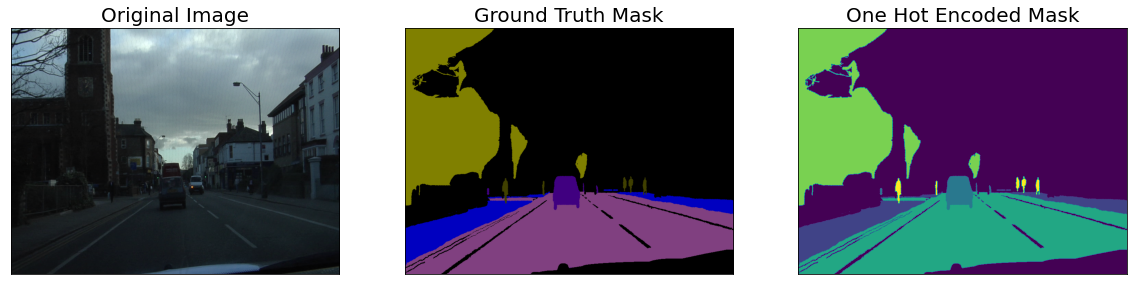

In [16]:
# create test dataloader (with preprocessing operation: to_tensor(...))

test_dataset = BuildingsDataset(
    x_test_dir, 
    y_test_dir, 
    #augmentation=get_validation_augmentation(), 
    #augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir, 
    #augmentation=get_validation_augmentation(),
    #augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
random_idx = 30
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

これ以下はやらなくても良い

In [17]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

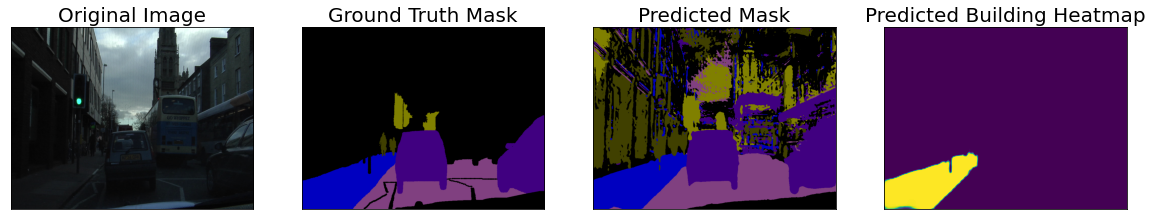

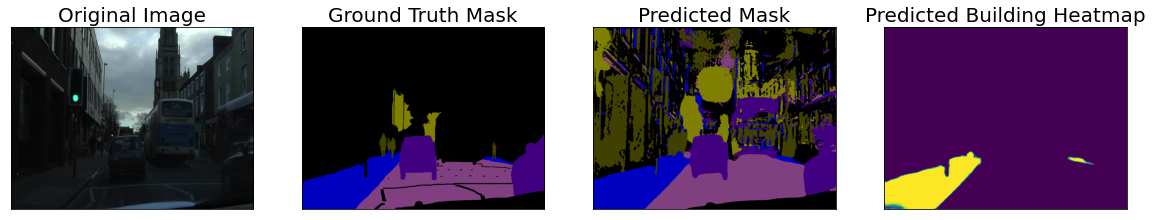

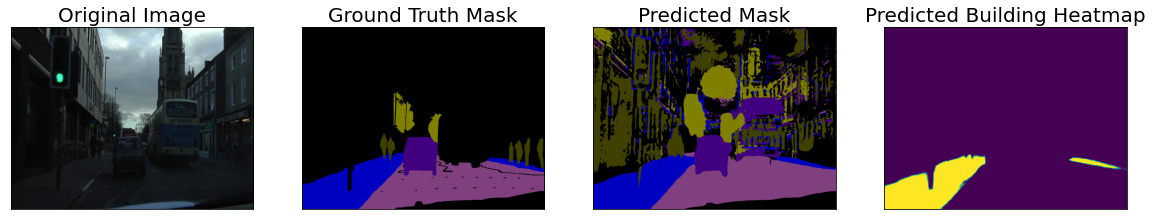

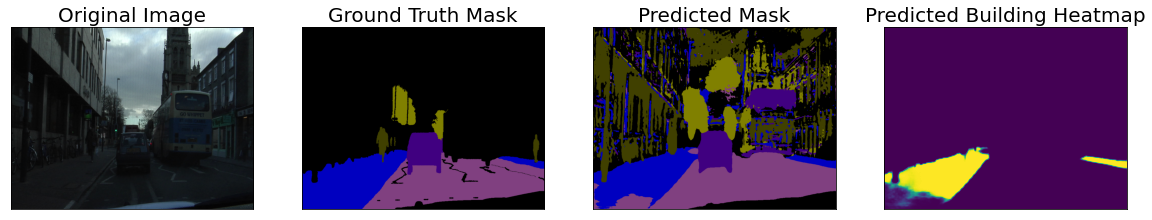

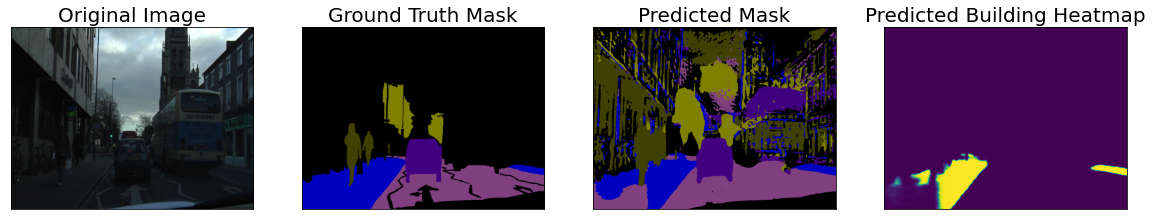

In [18]:
for idx in range(5):
#for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    #image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    #pred_building_heatmap = pred_mask[:,:,select_classes.index('Void', 'Sidewalk', 'Car', 'Road', 'Tree', 'Pedestrian')]
    pred_building_heatmap = pred_mask[:,:,select_classes.index('Sidewalk')]
    #pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    #gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

### Model Evaluation on Test Dataset

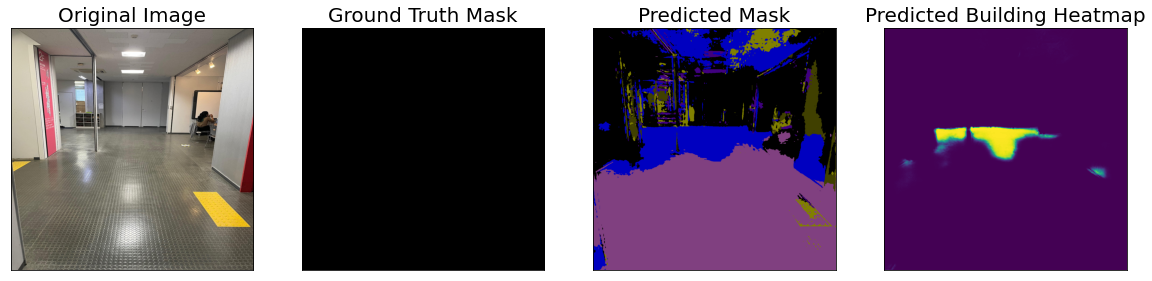

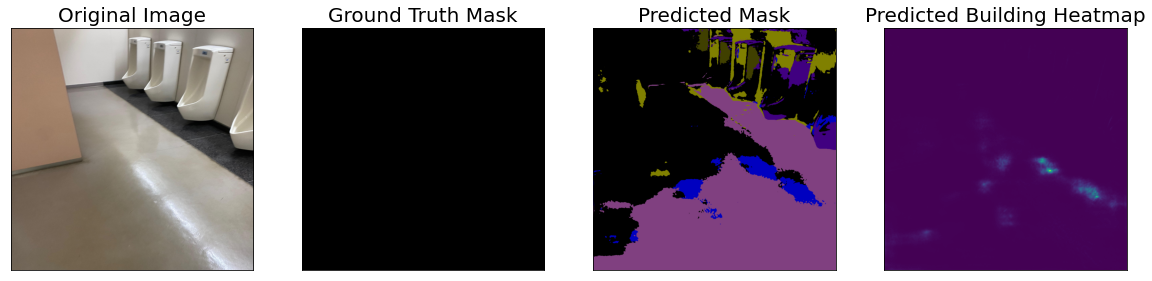

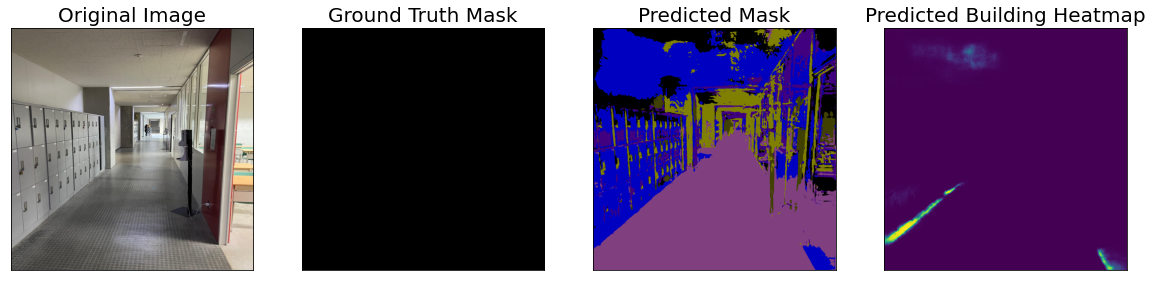

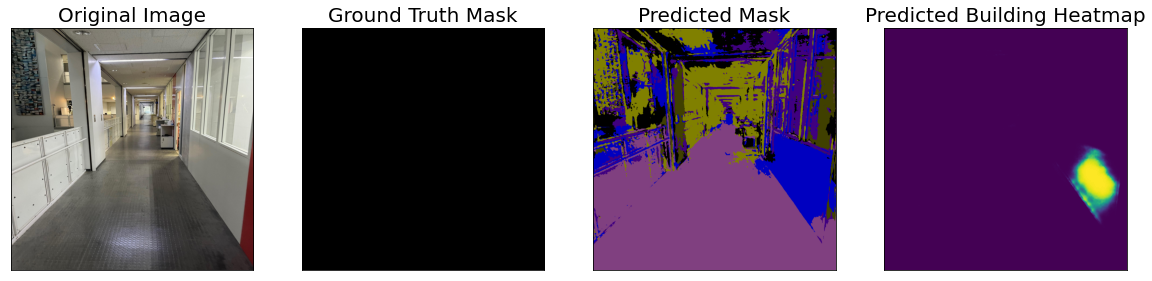

In [39]:
'''
from albumentations import Compose
from albumentations.augmentations.transforms import Resize, HorizontalFlip, RandomSizedCrop, HueSaturationValue
def get_compose(crop_min_max, image_height, image_width, hue_shift, saturation_shift, value_shift):
    # Resize image to (image_height, image_width) with 100% probability
    # Flip LR with 50% probability
    # Crop image and resize image to (image_height, image_width) with 100% probability
    # Change HSV from -hue_shift to +hue_shift and so on with 100% probability
    # Format 'pascal_voc' means label is given like [x_min, y_min, x_max, y_max]
    return Compose([Resize(image_height, image_width, p=1.0),
                     HorizontalFlip(p=0.5),
                     RandomSizedCrop(crop_min_max, image_height, image_width, p=1.0),
                     HueSaturationValue(hue_shift, saturation_shift, value_shift, p=1.0)],
                    bbox_params={'format':'pascal_voc', 'label_fields':['category_id']})

'''

def get_validation_augmentation2():   
    # Add sufficient padding to ensure image is divisible by 32
    # 画像のshapeが32で割り切れるようにPaddingするための関数
    #test_transform = [album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),]
    #test_transform = [album.PadIfNeeded(min_height=2784, min_width=2096, always_apply=True, border_mode=0),]   
    test_transform = [album.augmentations.Resize(1024, 1024, p=1.0),]
    return album.Compose(test_transform)

def get_validation_augmentation3():   
    # Add sufficient padding to ensure image is divisible by 32
    # 画像のshapeが32で割り切れるようにPaddingするための関数
    #test_transform = [album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),]
    test_transform = [album.PadIfNeeded(min_height=1024, 
                                min_width=1024, always_apply=True, border_mode=0),]
    return album.Compose(test_transform)

test_dataset = BuildingsDataset(
    '../input/mydataset/JPEGImages', 
    '../input/mydataset/SegmentationClassPNG', 
    augmentation=get_validation_augmentation2(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)
test_dataset_vis = BuildingsDataset(
    '../input/mydataset/JPEGImages', 
    '../input/mydataset/SegmentationClassPNG', 
    augmentation=get_validation_augmentation2(),
    class_rgb_values=select_class_rgb_values,
)
for idx in range(4):
#for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    #pred_building_heatmap = pred_mask[:,:,select_classes.index('Void', 'Sidewalk', 'Car', 'Road', 'Tree', 'Pedestrian')]
    pred_building_heatmap = pred_mask[:,:,select_classes.index('Sidewalk')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

In [31]:
from albumentations.augmentations import Resize

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

### Plot Dice Loss & IoU Metric for Train vs. Val

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()